# Parsing craigslist

## Lecture objectives

1. Provide more practice with scraping web pages and parsing text
2. Show how to handle errors ("exceptions") gracefully
3. Provide more pratice with `pandas` and plotting

Let's continue with the craigslist example from the previous lecture.

We've already figured out how to extract the information from a single post. Now, let's try and get all 120 posts from the first page of listings, and put them in a `pandas` dataframe. 

`pandas` can create a dataframe from many different data structures. But one of the easiest ways to is to create a list of dictionaries, and then tell `pandas` to convert that into a dataframe. 

Each element of the list will be a craigslist post. Within that list element, we have a dictionary of columns.

First of all, let's recreate the list of posts as before.

Remember that `posts` held our list of posts

In [1]:
from bs4 import BeautifulSoup

with open('../data/cl_posts.html', 'r') as f:  
    saved_content = f.read()
        
soup = BeautifulSoup(saved_content, features='html.parser')
posts = soup.find_all('li', class_='cl-search-result')
print(len(posts))

120


This is the code we had before.

In [2]:
print(posts[2].find(class_='titlestring').text)
print(posts[2].find(class_='titlestring')['href'])
print(posts[2].find(class_='meta').text.split('·')[1])
print(posts[2].find(class_= 'priceinfo').text)
print(posts[2].find(class_= 'post-bedrooms').text)
print(posts[2].find(class_= 'post-sqft').text)

SR- Brand new 2 bed, 2 bath  luxury unit with ROOTOP
https://losangeles.craigslist.org/wst/apa/d/los-angeles-sr-brand-new-bed-bath/7584176475.html
Hollywood
$3,295
2br
925ft2


So now, let's do the same to all posts. We will:
* Loop over the list, `posts`
* Use the code above to extract each element we want, and store it in a dictionary
* Create a list of these dictionaries, that we can then turn into a dataframe

Note that rather than printing each result, we'll assign it to a temporary variable.

In [3]:
import pandas as pd
postList = [] # empty list that we can append to. This will be our list of dictionaries

for post in posts:
    # create temporary variables with the attributes that we extract from each post
    title = post.find(class_='titlestring').text
    url = post.find(class_='titlestring')['href']
    neighborhood = post.find(class_='meta').text.split('·')[1]
    price = post.find(class_= 'priceinfo').text
    br = post.find(class_= 'post-bedrooms').text
    sf = post.find(class_= 'post-sqft').text

    # put them all in a dictionary
    postDict = {'title': title, 'url':url, 'neighborhood':neighborhood, 
                'price':price, 'br':br, 'sf':sf}
    
    # append that dictionary to our list
    postList.append(postDict)
    
# turn the list into a dataframe
df = pd.DataFrame(postList)

AttributeError: 'NoneType' object has no attribute 'text'

### Catching exceptions
What went wrong? Let's unpack this error.

It looks like we couldn't get our `br` variable, because there was no text.

So what if we back up and see what that object looks like, before we try and get the text? Note that `post` will still contain the element of the `posts` list where the error occurred.

In [5]:
type(post.find(class_= 'post-bedrooms'))

NoneType

Nothing! How come?

Aha. It's a `None` object - basically empty. And so we can't ask to get the text where nothing exists.

How can we be more robust to these errors (technically, "exceptions")?

One way is to use `try...except`. We `try` a block of code, and if something goes wrong, we execute the alternative code under `except`.

In [6]:
postList = [] # empty list that we can append to. This will be our list of dictionaries

for post in posts:
    try:
        # create temporary variables with the attributes that we extract from each post
        title = post.find(class_='titlestring').text
        url = post.find(class_='titlestring')['href']
        neighborhood = post.find(class_='meta').text.split('·')[1]
        price = post.find(class_= 'priceinfo').text
        br = post.find(class_= 'post-bedrooms').text
        sf = post.find(class_= 'post-sqft').text

        # put them all in a dictionary
        postDict = {'title': title, 'url':url, 'neighborhood':neighborhood, 
                    'price':price, 'br':br, 'sf':sf}
    
        # append that dictionary to our list
        postList.append(postDict)
    except: # we could also be more specific, e.g. except AttributeError:
        # this is only excecuted if the code under try fails
        # if there's a problem, we'll just append an empty dictionary
        postList.append({})
    
# turn the list into a dataframe
df = pd.DataFrame(postList)

df

,title,url,neighborhood,price,br,sf
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,"SR- Brand new 2 bed, 2 bath luxury unit with ...",https://losangeles.craigslist.org/wst/apa/d/lo...,Hollywood,"$3,295",2br,925ft2
3,NaN,NaN,NaN,NaN,NaN,NaN
4,Affordable one bedroom near the beach,https://losangeles.craigslist.org/wst/apa/d/sa...,Santa Monica,"$2,382",1br,655ft2
...,...,...,...,...,...,...
115,NaN,NaN,NaN,NaN,NaN,NaN
116,***********NEW BUILT GORGEOUS 4 BEDS 4.5 BATHS...,https://losangeles.craigslist.org/sfv/apa/d/su...,************** SUN VALLEY *************,"$5,995",4br,2500ft2
117,NaN,NaN,NaN,NaN,NaN,NaN
118,"In-Unit Washer/Dryer, Solid Surface Flooring, ...",https://losangeles.craigslist.org/sfv/apa/d/sa...,"25910 Tournament Rd, Valencia, CA","$2,290",1br,720ft2


So we find the errant rows - 0, 1, and lots of others.

The `try...except` syntax is useful, but a blunt instrument. Notice that we lose all the data for that posting, not just the housing size.

As an alternative, we could explicitly check for missing data at each step.

In [7]:
postList = [] # empty list that we can append to. This will be our list of dictionaries

for post in posts:
    title = post.find(class_='titlestring').text
    url = post.find(class_='titlestring')['href']
    neighborhood = post.find(class_='meta').text.split('·')[1]
    price = post.find(class_= 'priceinfo').text
    br_tmp = post.find(class_= 'post-bedrooms')
    if br_tmp is None:
        br = None
    else:
        br = br_tmp.text
    
    # we can also have our if..else statements as a one-liner
    sf_tmp = post.find(class_= 'post-sqft')
    sf = None if sf_tmp is None else sf_tmp.text

    # put them all in a dictionary
    postDict = {'title': title, 'url':url, 'neighborhood':neighborhood, 
                'price':price, 'br':br, 'sf':sf}
    
    # append that dictionary to our list
    postList.append(postDict)
    
df = pd.DataFrame(postList)
df

,title,url,neighborhood,price,br,sf
0,1050 N. Orange Grove Ave./All Utilities Includ...,https://losangeles.craigslist.org/wst/apa/d/we...,West Hollywood,"$1,195",None,None
1,BEAUTIFUL DORMITORY STYLE HOUSING AVAILABLE - ...,https://losangeles.craigslist.org/wst/apa/d/to...,westside-southbay-310,"$1,025",None,None
2,"SR- Brand new 2 bed, 2 bath luxury unit with ...",https://losangeles.craigslist.org/wst/apa/d/lo...,Hollywood,"$3,295",2br,925ft2
3,Very nice upgraded 1 bedroom 1 bath unit,https://losangeles.craigslist.org/wst/apa/d/ga...,Gardena,"$1,910",1br,None
4,Affordable one bedroom near the beach,https://losangeles.craigslist.org/wst/apa/d/sa...,Santa Monica,"$2,382",1br,655ft2
...,...,...,...,...,...,...
115,Light and Bright! See Photos! Vintage Bldg / P...,https://losangeles.craigslist.org/lac/apa/d/lo...,Los Angeles / Westlake District / DTLA,"$2,195",1br,None
116,***********NEW BUILT GORGEOUS 4 BEDS 4.5 BATHS...,https://losangeles.craigslist.org/sfv/apa/d/su...,************** SUN VALLEY *************,"$5,995",4br,2500ft2
117,******GREAT LOCATION SHERMAN OAKS NEAR VENTURA...,https://losangeles.craigslist.org/sfv/apa/d/sh...,**************SHERMAN OAKS / NEAR VENTURA BLVD...,"$2,995",3br,None
118,"In-Unit Washer/Dryer, Solid Surface Flooring, ...",https://losangeles.craigslist.org/sfv/apa/d/sa...,"25910 Tournament Rd, Valencia, CA","$2,290",1br,720ft2


Notice that we got some partial data for these rows.

### Plotting

Now let's plot the distribution of price. A box plot would be a good choice here.

ValueError: boxplot method requires numerical columns, nothing to plot.

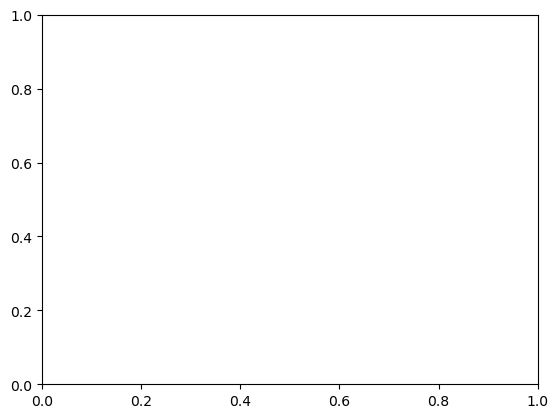

In [8]:
df.boxplot('price')

Oops. What went wrong? 

The error message isn't terribly helpful, so let's look at the data.

In [9]:
df.price.head()

0    $1,195
1    $1,025
2    $3,295
3    $1,910
4    $2,382
Name: price, dtype: object

Aha. We can't do a boxplot of a string! So let's convert it to a number. This is a three-stage process:
* Remove the `$` (replace `$` with an empty string)
* Do the same for the `,`
* Convert to a float. The pandas `astype` function is useful here.

Let's do this and store the output in a new column, `price_numeric`.

In [10]:
df['price_numeric'] = df.price.str.replace('$','').str.replace(',','').astype(float)

<div class="alert alert-block alert-info">
<strong>Exercise:</strong> Convert the sf and br fields to numeric in the same way.
</div>

In [11]:
# for simplicity, I'll just write over the old column name rather than create 
# new columns sf_numeric and br_numeric

df['sf'] = df.sf.str.replace('ft2','').astype(float)
df['br'] = df.br.str.replace('br','').astype(float)
df[['sf','br']]

,sf,br
0,NaN,NaN
1,NaN,NaN
2,925.0,2.0
3,NaN,1.0
4,655.0,1.0
...,...,...
115,NaN,1.0
116,2500.0,4.0
117,NaN,3.0
118,720.0,1.0


<Axes: >

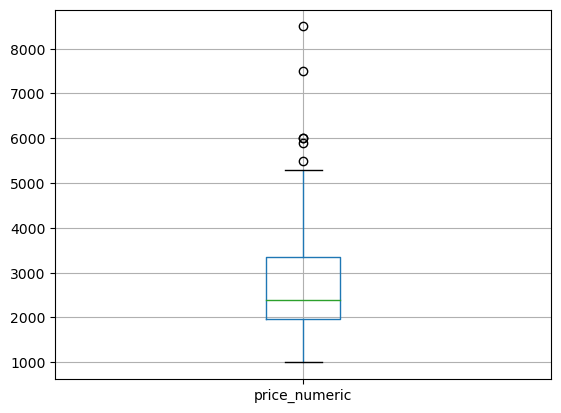

In [12]:
%matplotlib inline
df.boxplot('price_numeric')

We can also break it out by neighborhood using the `by` argument.

But what's the problem here?

<Axes: title={'center': 'price_numeric'}, xlabel='neighborhood'>

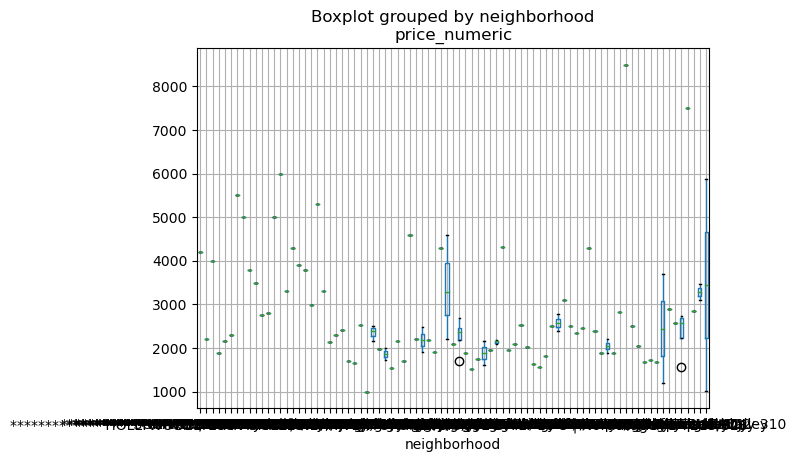

In [13]:
df.boxplot('price_numeric', by='neighborhood')

There are several ways to examine the contents of a pandas DataFrame column. `unique()` can be useful.

Here, we see that there isn't a fixed set of neighborhood names, and so further cleaning would be needed.

In [14]:
df.neighborhood.unique()

array(['West Hollywood', 'westside-southbay-310', 'Hollywood', 'Gardena',
       'Santa Monica', 'san fernando valley', 'Glendale', 'Reseda',
       'West Los Angeles', 'Van Nuys/Lake Balboa ADJ',
       'central LA 213/323', '44045 15th St W, Lancaster, CA',
       'Marina Del Rey', 'Koreatown', 'Duarte', 'Monrovia', 'Covina',
       'West Covina', 'Tarzana',
       '**************** PACOIMA ****************',
       '*****************NORTH HOLLYWOOD******************',
       '*********** NORTH HOLLYWOOD *********', 'Paramount',
       'long beach / 562', 'Moments to Ventura Boulevard',
       'Close to Ventura Boulevard', 'South of Ventura Boulevard',
       '************** SUN VALLEY *************',
       '3205 Los Feliz Boulevard, Los Angeles, CA',
       '************* HOLLYWOOD / LOS ANGELES *****************',
       '18414 W. Jakes Way, Canyon Country, CA', 'VENICE BEACH BOARDWALK',
       '******** SUN VALLEY ***************',
       '************* SUN VALLEY ************',


What about the relationship between prices and the apartment size?

<Axes: xlabel='sf', ylabel='price_numeric'>

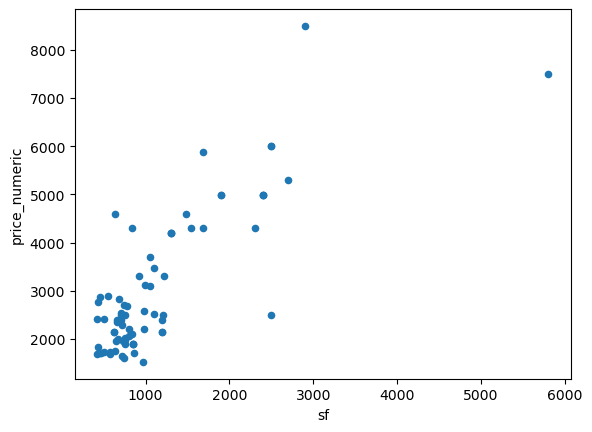

In [15]:
df.plot('sf', 'price_numeric', kind='scatter')

So now we've created a dataframe that extracts all the posts on the first page! 

There's still quite a bit to do. For example:

* We only have one page, and it would be useful to get data from the subsequent pages
* Our neighborhood field is really dirty, so it's hard to do any mapping
* We don't have any information about parking
* We don't have the geographic coordinates (lat/lon)

But let's leave those for future work. 

<div class="alert alert-block alert-info">
<h3>Key Takeaways</h3>
<ul>
  <li>Scraping unstructured webpages involves more detective work and trial and error.</li>
  <li>Some will have a consistent format and helpful class codes and html tags. Some won't.</li>
  <li>Your code will need to be robust to missing fields and other inconsistencies in page formatting.</li>
  <li>Be nice! You may need to slow the pace of your requests down.</li>
</ul>
</div>